In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copia
from tqdm import tqdm
import bambi as bmb
import arviz as az

In [2]:
df = pd.read_csv('number_of_works_individuals.csv')
df.sample(5)

,Unnamed: 0,individual_wikidata_id,birthyear,region_name,count_works
88502,88502,Q3903068,1445.0,Southwestern Europe,5.0
141269,141269,Q111205773,1846.0,Italy,0.0
136390,136390,Q93493282,1754.0,Southern France,2.0
301851,301851,Q3557072,1832.0,Northwestern Europe,0.0
405227,405227,Q66305949,1842.0,Low countries,0.0


In [3]:
df['region_name'].value_counts()

Western Europe         132680
Northwestern Europe    105738
German world            40629
Germany                 31895
France                  24577
Eastern Europe          22102
Southwestern Europe     19338
British Islands         18580
Italy                   18051
United Kingdom          17521
Northern France         15436
Central Europe          13297
Northern Italy          12993
Low countries           12204
Nordic countries         9668
Spain                    7719
Netherlands              7691
Southern France          5029
Slav world               4892
Austria                  4647
Sweden                   4607
Belgium                  4516
Southern Italy           4164
Switzerland              4089
Denmark                  2762
Ottoman world            2723
mediterranean World      2209
Muslim world             2169
Chinese world            2130
Balkans                  2040
Greek World              1935
Japan                    1763
Arabic world             1448
Norway    

In [4]:
df['count_works'] = [i if i > 0 else 1 for i in df['count_works']]

Lots of writers with 0 works: ignore them? Or one-smoothing?

In [5]:
print(len(df))
df = df[df['count_works'] > 0]
print(len(df))
df.sample(5)

571776
571776


,Unnamed: 0,individual_wikidata_id,birthyear,region_name,count_works
433306,433306,Q112262748,1743.0,German world,1.0
513527,513527,Q1565839,1828.0,Western Europe,1.0
69500,69500,Q3094924,1846.0,Northern France,2.0
290004,290004,Q968197,1849.0,German world,1.0
179334,179334,Q29168216,1782.0,Northwestern Europe,1.0


count    571776.000000
mean       1713.800866
std         250.810199
min        -850.000000
25%        1687.000000
50%        1789.000000
75%        1825.000000
max        1850.000000
Name: birthyear, dtype: float64


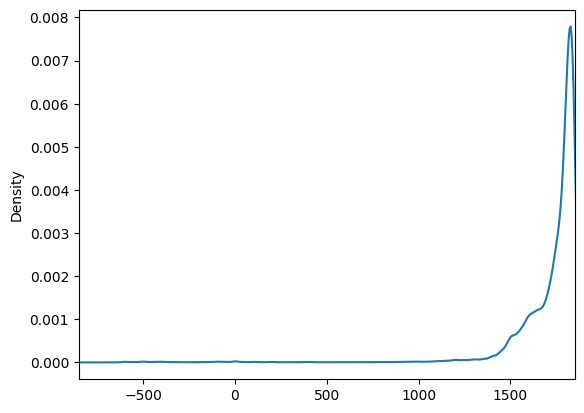

In [6]:
print(df['birthyear'].describe())
df['birthyear'].plot.kde()
plt.xlim(df['birthyear'].min(), df['birthyear'].max());

In [7]:
temporal_cnts = []
window = 50
for year in range(int(df['birthyear'].min() + window), int(df['birthyear'].max() - window + 1)):
    y1, y2 = year - window, year + window
    d = df[(df['birthyear'] >= y1) & (df['birthyear'] <= y2)]
    S_obs = len(d)
    N = sum(d['count_works'])
    #div = copia.diversity(d['count_works'], method='chao1', CI=True, n_iter=100)
    div = copia.diversity(d['count_works'], method='chao1')
    ch1 = div
    #ch1 = div['richness']
    #ch1_lci = div['lci']
    #ch1_uci = div['uci']
    cnts = np.array(d['count_works'].astype(int))
    #temporal_cnts.append((year, S_obs, N, ch1, ch1_lci, ch1_uci))
    temporal_cnts.append((year, S_obs, N, ch1))
#temporal_cnts = pd.DataFrame(temporal_cnts, columns=['year', 'S', 'N', 'chao1', 'chao1_lci', 'chao1_uci'])
temporal_cnts = pd.DataFrame(temporal_cnts, columns=['year', 'S', 'N', 'chao1'])
temporal_cnts.sample(5)

,year,S,N,chao1
1798,998,1026,42367.0,6195.039008
1438,638,400,25789.0,2136.043791
2383,1583,54688,429110.0,483933.357710
1593,793,592,68828.0,3699.724078
1431,631,406,26161.0,2486.045488


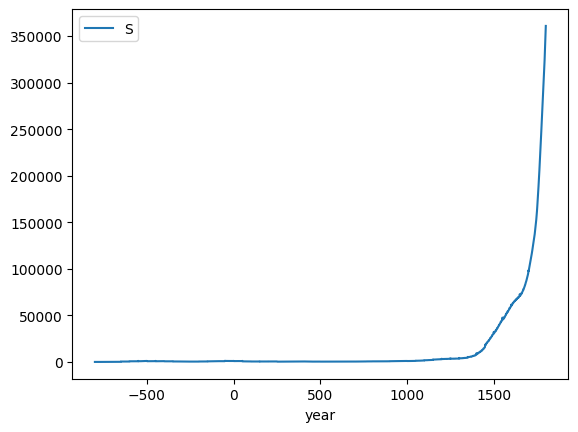

In [8]:
temporal_cnts.plot('year', 'S');

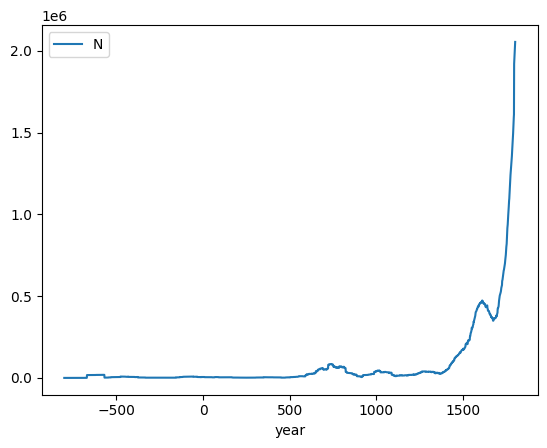

In [9]:
temporal_cnts.plot('year', 'N');

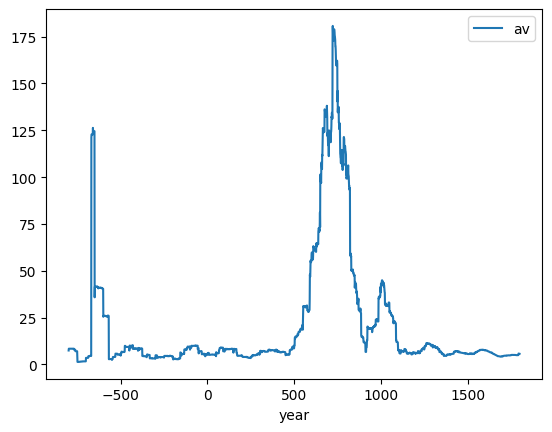

In [10]:
temporal_cnts['av'] = temporal_cnts['N'] / temporal_cnts['S']
temporal_cnts.plot('year', 'av');

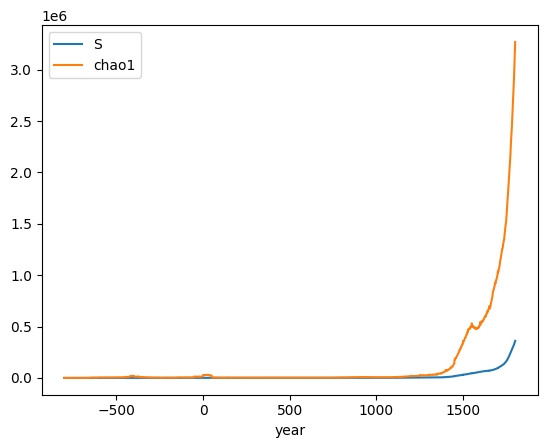

In [11]:
ax = temporal_cnts.plot('year', 'S');
temporal_cnts.plot('year', 'chao1', ax=ax);

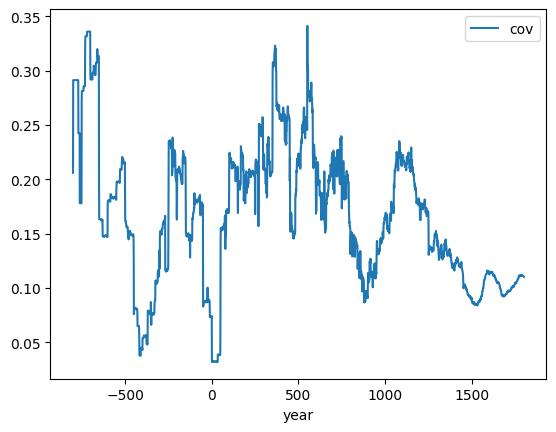

In [12]:
temporal_cnts['cov'] = temporal_cnts['S'] / temporal_cnts['chao1']
#temporal_cnts['cov_lci'] = temporal_cnts['S'] / temporal_cnts['chao1_lci']
#temporal_cnts['cov_uci'] = temporal_cnts['S'] / temporal_cnts['chao1_uci']

ax = temporal_cnts.plot('year', 'cov');
#temporal_cnts.plot('year', 'cov_lci', ax=ax, c='grey');
#temporal_cnts.plot('year', 'cov_uci', ax=ax, c='grey');
#ax.fill_between(temporal_cnts['year'], temporal_cnts['cov_lci'], temporal_cnts['cov_uci'], color='lightblue');

In [13]:
region_df = pd.read_csv('ENS - Cultural Index - Countries Databases - region_level.csv')
region_df = region_df[region_df['level'] == 2]
regions = set(region_df['region_name'])
print(regions)

{'France', 'Indian world', 'German world', 'Arabic world', 'Italy', 'Korea', 'Portugal', 'Eastern Europe', 'United Kingdom', 'Low countries', 'Central Europe', 'Spain', 'Balkans', 'Persian world', 'Slav world', 'Nordic countries', 'Greek World', 'Latin World', 'Japan', 'Chinese world'}


## Generalized Chao

In [14]:
print(len(df))
df = df[df['region_name'].isin(regions)]
print(len(df))

571776
183109


In [15]:
from sklearn.preprocessing import StandardScaler
date_scaler = StandardScaler()
df['date'] = date_scaler.fit_transform(np.array(df['birthyear']).reshape(-1, 1)) # What does it mean to do that?
df['region'] = df['region_name'].astype('category')
df.head()

,Unnamed: 0,individual_wikidata_id,birthyear,region_name,count_works,date,region
2,2,Q100035,1800.0,German world,2.0,0.323468,German world
6,6,Q1000899,1840.0,German world,2.0,0.450479,German world
8,8,Q1001063,1848.0,Eastern Europe,2.0,0.475881,Eastern Europe
9,9,Q1001063,1848.0,Central Europe,2.0,0.475881,Central Europe
12,12,Q100116,1654.0,German world,3.0,-0.140120,German world


In [16]:
df['count'] = df['count_works'].astype(int)
df = df[df['count'].isin({1, 2})]
df.head()

,Unnamed: 0,individual_wikidata_id,birthyear,region_name,count_works,date,region,count
2,2,Q100035,1800.0,German world,2.0,0.323468,German world,2
6,6,Q1000899,1840.0,German world,2.0,0.450479,German world,2
8,8,Q1001063,1848.0,Eastern Europe,2.0,0.475881,Eastern Europe,2
9,9,Q1001063,1848.0,Central Europe,2.0,0.475881,Central Europe,2
16,16,Q100156894,1817.0,Nordic countries,1.0,0.377448,Nordic countries,1


In [17]:
df['y'] = df['count'].map({1: 0, 2: 1})
df

,Unnamed: 0,individual_wikidata_id,birthyear,region_name,count_works,date,region,count,y
2,2,Q100035,1800.0,German world,2.0,0.323468,German world,2,1
6,6,Q1000899,1840.0,German world,2.0,0.450479,German world,2,1
8,8,Q1001063,1848.0,Eastern Europe,2.0,0.475881,Eastern Europe,2,1
9,9,Q1001063,1848.0,Central Europe,2.0,0.475881,Central Europe,2,1
16,16,Q100156894,1817.0,Nordic countries,1.0,0.377448,Nordic countries,1,0
...,...,...,...,...,...,...,...,...,...
571765,571765,Q6169937,1789.0,France,1.0,0.288541,France,1,0
571768,571768,Q41260928,1830.0,German world,1.0,0.418726,German world,1,0
571770,571770,Q4228920,1850.0,Eastern Europe,1.0,0.482232,Eastern Europe,1,0
571771,571771,Q4228920,1850.0,Central Europe,1.0,0.482232,Central Europe,1,0


In [18]:
#df = df.sample(100000)

In [19]:
df['y'].value_counts(dropna=False)

0    151955
1      7234
Name: y, dtype: int64

In [20]:
df['date'].describe()

count    159189.000000
mean          0.015262
std           0.974568
min          -8.090976
25%          -0.009934
50%           0.304417
75%           0.412376
max           0.482232
Name: date, dtype: float64

In [21]:
intercept_model = bmb.Model('y ~ 1', df, family='bernoulli')
intercept_fit = intercept_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(intercept_fit)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.045,0.012,-3.068,-3.024,0.0,0.0,1503.0,2858.0,1.0


In [22]:
date_model = bmb.Model('y ~ date', df, family='bernoulli')
date_fit = date_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.plot_forest(date_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, date]


EOFError: 

In [ ]:
az.summary(date_fit)

In [ ]:
region_model = bmb.Model('y ~ region', df, family='bernoulli')
region_fit = region_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(region_fit)

In [ ]:
az.plot_forest(region_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

In [ ]:
covariate_model = bmb.Model('y ~ region + date', df, family='bernoulli')
covariate_fit = covariate_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(covariate_fit)
az.plot_forest(covariate_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

In [ ]:
region_model_vi = bmb.Model('y ~ (1|region)', df, family='bernoulli')
region_fit_vi = region_model_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(region_fit_vi)

In [ ]:
models_dict = {
    "date": date_fit,
    "region": region_fit,
    "region_vi": region_fit_vi,
#     "covariate": covariate_fit,
     "intercept": intercept_fit
}

# loo_compare = az.compare(models_dict, ic='LOO')
waic_compare = az.compare(models_dict, ic='WAIC')

In [ ]:
az.plot_compare(waic_compare, insample_dev=True);

In [ ]:
waic_compare

In [ ]:
df_compare = pd.concat([loo_compare, waic_compare], axis=1)
df_compare

In [ ]:
DATE = np.linspace(int(df['birthyear'].min()), int(df['birthyear'].max()))
DATE_SCALED = date_scaler.transform(DATE.reshape(-1, 1)).flatten()

In [ ]:
fig, ax = plt.subplots()
handles = []
i = 0

new_data = pd.DataFrame({
            "date": DATE_SCALED,
        })
new_idata = date_model.predict(date_fit, data=new_data, inplace=False)
mean = new_idata.posterior["y_mean"].values

az.plot_hdi(DATE, mean, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel(f"P($f_2$)")
ax.legend(handles=handles, loc="upper left");